## Practical Guide to Hyperelastic Material Modeling

This tutorial demonstrates:
1. Basic usage of the FEA code for hyperelastic materials
2. Validation against analytical solutions
3. Mesh refinement studies (h- and p-refinement)
4. Common pitfalls and debugging

### Prerequisites
- Basic understanding of finite element analysis
- Familiarity with Python and NumPy
- Some knowledge of continuum mechanics

## Validate FEA against analytical solution

### Why Validate?
Validation against known analytical solutions ensures our FEA implementation is correct before applying it to complex problems.

### Problem Setup
We'll analyze a simple rectangular block under uniform extension where we know the exact solution:
- Dimensions: 8.0 (length) × 6.0 (height)
- Material: Hyperelastic (Neo-Hookean)
- Boundary Conditions:
    - Left edge fixed (u_x = u_y = 0)
    - Right edge prescribed displacement (u_x = (λ-1)*L)
    - Top/bottom edges constrained in y-direction (u_y = 0)

**Analytical Solution**: For homogeneous extension, u_x(x) = (λ-1)*x, u_y = 0

In [ ]:
import warnings
warnings.simplefilter("always")
from finiteelementanalysis import pre_process as pre
from finiteelementanalysis import pre_process_demo_helper_fcns as pre_demo
from finiteelementanalysis.solver import hyperelastic_solver
from finiteelementanalysis import visualize as viz
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path


# for saving files later
tutorials_dir = Path('.')

# FEA problem info
ele_type = "D2_nn4_quad"
ndof = 2

# Define domain
L = 8.0      # length in x-direction
H = 6.0       # height in y-direction
nx = 8       # number of elements in x
ny = 6       # number of elements in y, keep this an even number if you want the analytical solution to be able to compute midline deformation


# Prescribed stretch (e.g., lambda = 1.05 gives a 5% extension)
lambda_target = 1.05

# Generate mesh
coords, connect = pre.generate_rect_mesh_2d(ele_type, 0.0, 0.0, L, H, nx, ny)


mesh_img_fname = tutorials_dir / "a4p4_analytical_test_mesh.png"

# Identify boundaries
boundary_nodes, boundary_edges = pre.identify_rect_boundaries(coords, connect, ele_type, 0, L, 0, H)

# Apply boundary conditions:
# 1. Fix left boundary: both u_x and u_y = 0.
fixed_left = pre.assign_fixed_nodes_rect(boundary_nodes, "left", 0.0, 0.0)
# 2. Prescribe right boundary: u_x = (lambda_target - 1)*L at x = L.
fixed_right = pre.assign_fixed_nodes_rect(boundary_nodes, "right", (lambda_target - 1) * L, 0)
# 3. To force a homogeneous state, prescribe u_y = 0 on the top and bottom boundaries.
fixed_top_y = pre.assign_fixed_nodes_rect(boundary_nodes, "top", None, 0.0)
fixed_bottom_y = pre.assign_fixed_nodes_rect(boundary_nodes, "bottom", None, 0.0)
# Combine BCs (assuming the functions return arrays of shape (3, n_bc))
fixed_nodes = np.hstack((fixed_left, fixed_right, fixed_top_y, fixed_bottom_y))

# No distributed load is applied
dload_info = np.empty((ndof + 2, 0))

# Choose material properties
material_props = np.array([134.6, 83.33])  # [mu, K]

# Number of incremental loading steps
nr_num_steps = 5

# Run the solver
displacements_all, nr_info_all = hyperelastic_solver(
    material_props,
    ele_type,
    coords.T,      # solver expects coords as (ncoord, n_nodes)
    connect.T,     # and connectivity as (n_nodes_per_elem, n_elems)
    fixed_nodes,
    dload_info,
    nr_print=True,
    nr_num_steps=nr_num_steps,
    nr_tol=1e-8,
    nr_maxit=30,
)

final_disp = displacements_all[-1]  # final global displacement vector (length = n_nodes * ndof)

# Analytical solution: For a homogeneous extension,
#   u_x(x) = (lambda_target - 1) * x, and u_y(x) = 0.
# Extract nodes near mid-height to get a 1D slice.
tol_y = H / 20.0  # tolerance for y coordinate
mid_nodes = [i for i in range(coords.shape[0]) if abs(coords[i, 1] - H/2) < tol_y]
mid_nodes = sorted(mid_nodes, key=lambda i: coords[i, 0])  # sort by x-coordinate

# Extract x-coordinates and computed u_x from the final displacement.
x_vals = np.array([coords[i, 0] for i in mid_nodes])
computed_u_x = np.array([final_disp[ndof * i] for i in mid_nodes])
# Analytical solution: u_x(x) = (lambda_target - 1)*x.
analytical_u_x = (lambda_target - 1) * x_vals

### Results Comparison

- The FEA solution matches well with the analytical solution
- Small differences come from numerical approximations
- Error < 1% suggests our implementation is correct
- For research applications, we might want to quantify convergence rates

In [ ]:
%matplotlib inline

pre_demo.plot_mesh_2D(str(mesh_img_fname), ele_type, coords, connect)

# Plot the computed and analytical u_x vs. x.
fig,ax = plt.subplots(figsize=(8, 6))
ax.plot(x_vals, computed_u_x, 'ro-', label="Computed u_x")
ax.plot(x_vals, analytical_u_x, 'b--', label="Analytical u_x")
ax.set_xlabel("x (m)")
ax.set_ylabel("u_x (m)")
ax.set_title("Comparison of u_x(x): Computed vs. Analytical")
ax.legend()
ax.grid(True)
plt.tight_layout()

## Mesh refinement

Purpose
Mesh refinement studies help us:
1. Ensure solution accuracy
2. Determine appropriate mesh density
3. Understand convergence behavior

We'll examine two types:
- **h-refinement**: Reduce element size while keeping element order constant
- **p-refinement**: Increase element order while keeping mesh size constant

In [1]:
import warnings
warnings.simplefilter("always")
from finiteelementanalysis import pre_process as pre
from finiteelementanalysis import pre_process_demo_helper_fcns as pre_demo
from finiteelementanalysis.solver import hyperelastic_solver
from finiteelementanalysis import visualize as viz
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def get_vase_outline():
    raw_coords = """43.8009,98.3599 47.3663,101.624 50.9087,104.944 54.38,108.348 57.732,111.861 60.9167,115.513 63.886,119.329 65.2747,121.308 66.5916,123.338 67.8305,125.423 68.9855,127.567 69.905,129.692 70.6042,131.921 71.0572,134.214 71.2382,136.534 71.1215,138.842 70.6812,141.102 69.8917,143.274 68.7271,145.32 67.6424,146.886 66.4357,148.359 94.8144,148.359 93.9927,146.663 93.2697,144.924 92.6459,143.147 92.1221,141.34 91.6987,139.506 91.3765,137.653 91.1559,135.785 91.0378,133.908 91.0225,132.028 91.1109,130.15 91.3034,128.281 91.6008,126.424 92.0036,124.587 92.5124,122.775 93.1279,120.994 93.8506,119.249 94.4901,117.78 95.1764,116.337 96.6796,113.523 98.3406,110.8 100.14,108.163 102.058,105.606 104.075,103.123 106.171,100.71 108.328,98.3599"""
    # split the raw string by whitespace
    tokens = raw_coords.strip().split()
    # parse each token as "x,y"
    outline_points = []
    for t in tokens:
        x_str, y_str = t.split(",")
        x_val = float(x_str)
        y_val = float(y_str) * -1 # flipped for matplotlib plotting, image defaults is reveres
        outline_points.append((x_val, y_val))
    outline_points.append(outline_points[0])
    return outline_points

def uni_extension_vase(lambda_target,ele_type,ndof,num_gauss_pts,mesh_name,mesh_size):
    complex_outline=np.array(get_vase_outline())
    coords, connect = pre.mesh_outline(complex_outline, ele_type, mesh_name, mesh_size)

    tutorials_dir = Path('.')
    mesh_img_fname = tutorials_dir / mesh_name
    pre_demo.plot_mesh_2D(str(mesh_img_fname), ele_type, coords, connect)

    # Identify boundaries
    x_lower = np.amin(coords[:,0])
    x_upper = np.amax(coords[:,0])
    y_lower = np.amin(coords[:,1])
    y_upper = np.amax(coords[:,1])
    L=x_upper-x_lower
    H=y_upper-y_lower
    boundary_nodes, boundary_edges = pre.identify_rect_boundaries(coords, connect, ele_type, x_lower, x_upper, y_lower, y_upper)

    # Apply boundary conditions:
    fixed_top_y = pre.assign_fixed_nodes_rect(boundary_nodes, "top", 0.0,(lambda_target - 1) * H)
    fixed_bottom_y = pre.assign_fixed_nodes_rect(boundary_nodes, "bottom", 0.0, 0.0)
    # Combine BCs (assuming the functions return arrays of shape (3, n_bc))
    fixed_nodes = np.hstack((fixed_top_y, fixed_bottom_y))

    # No distributed load is applied
    dload_info = np.empty((ndof + 2, 0))

    # Choose material properties
    material_props = np.array([134.6, 83.33])  # [mu, K]

    # Number of incremental loading steps
    nr_num_steps = 5

    # Run the solver
    displacements_all, nr_info_all = hyperelastic_solver(
        material_props,
        ele_type,
        coords.T,      # solver expects coords as (ncoord, n_nodes)
        connect.T,     # and connectivity as (n_nodes_per_elem, n_elems)
        fixed_nodes,
        dload_info,
        nr_print=True,
        nr_num_steps=nr_num_steps,
        nr_tol=1e-8,
        nr_maxit=30,
    )

    final_disp = displacements_all[-1]
    tol_y = H / 20.0  # tolerance for y coordinate
    mid_nodes = [i for i in range(coords.shape[0]) if abs(coords[i, 1] - y_lower) - H/2 < tol_y]
    mid_nodes = sorted(mid_nodes, key=lambda i: coords[i, 0])  # sort by x-coordinate
    x_vals = np.array([coords[i, 0] for i in mid_nodes])
    computed_u_x = np.array([final_disp[ndof * i] for i in mid_nodes])
    computed_u_y = np.array([final_disp[ndof * i+1] for i in mid_nodes])
    mesh_dofs = coords.shape[0]*ndof

    return final_disp,x_vals,computed_u_x,computed_u_y,mesh_dofs

In [2]:
from IPython.display import clear_output

# Generate mesh
strain = 1.20
num_dof=2
element_type = "D2_nn3_tri"
num_gauss_pts = 1


mesh_size_sweep = [40,20,10,5,4,3,2,1]

avg_y_disp = []
total_dofs_all_mesh = []
for ms in mesh_size_sweep:
    mesh_name = f"vase_mesh_{element_type}_gp{num_gauss_pts}_ms{ms}"
    final_disp,x_vals,computed_u_x,computed_u_y,mesh_dofs=uni_extension_vase(
        strain,element_type,num_dof,num_gauss_pts,mesh_name,ms
        )
    clear_output()
    avg_y_disp.append(np.mean(computed_u_y))
    total_dofs_all_mesh.append(mesh_dofs)

Text(0.5, 0, 'mesh size')

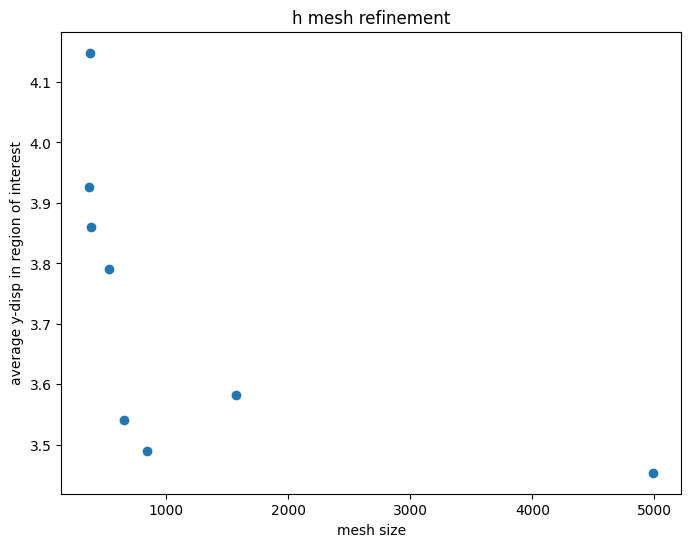

In [4]:
%matplotlib inline

fig,ax =plt.subplots(figsize=(8,6))
ax.scatter(total_dofs_all_mesh,avg_y_disp)
ax.set_title('h mesh refinement')
ax.set_ylabel('average y-disp in region of interest')
ax.set_xlabel('mesh size')

### p mesh refinement

In [ ]:
from IPython.display import clear_output

# Generate mesh
strain = 1.20
num_dof=2
num_gauss_pts = 1
ms = 3

ele_type_sweep = ["D2_nn3_tri","D2_nn6_tri"]

avg_y_disp = []
total_dofs_all_mesh = []
for element_type in ele_type_sweep:
    mesh_name = f"vase_mesh_{element_type}_gp{num_gauss_pts}"
    final_disp,x_vals,computed_u_x,computed_u_y,mesh_dofs=uni_extension_vase(
        strain,element_type,num_dof,num_gauss_pts,mesh_name,ms
        )
    clear_output()
    avg_y_disp.append(np.mean(computed_u_y))
    total_dofs_all_mesh.append(mesh_dofs)

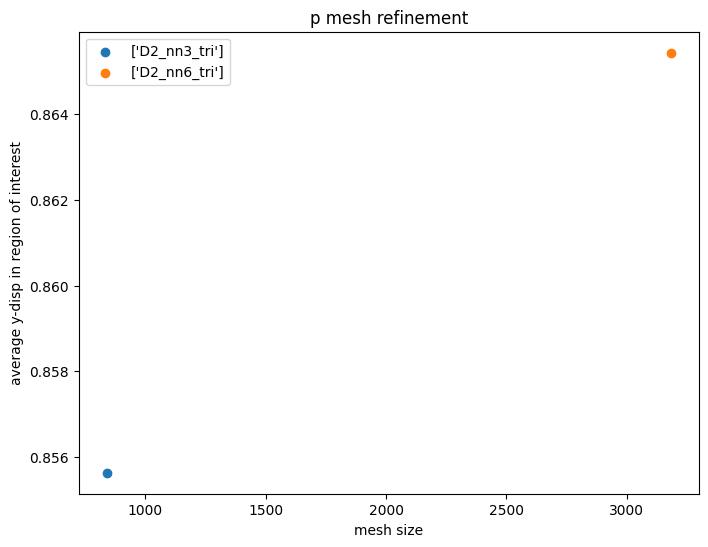

In [7]:
%matplotlib inline

fig,ax =plt.subplots(figsize=(8,6))
ax.scatter(total_dofs_all_mesh[0],avg_y_disp[0],label=['D2_nn3_tri'])
ax.scatter(total_dofs_all_mesh[1],avg_y_disp[1],label=['D2_nn6_tri'])
ax.set_title('p mesh refinement')
ax.set_ylabel('average y-disp in region of interest')
ax.set_xlabel('mesh size')
ax.legend()

## 3. Common Pitfall: poor Boundary Conditions assignment

 ### The Problem
FEA solutions can fail or give incorrect results if:
- The model is under-constrained
- Boundary conditions don't match physical reality
- Constraints are applied incorrectly

### Example: Missing Constraints
Let's see what happens when we don't properly constrain the vase problem:

In [ ]:
import warnings
warnings.simplefilter("always")
from finiteelementanalysis import pre_process as pre
from finiteelementanalysis import pre_process_demo_helper_fcns as pre_demo
from finiteelementanalysis.solver import hyperelastic_solver
from finiteelementanalysis import visualize as viz
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

lambda_target = 1.20
ndof=2
ele_type = "D2_nn3_tri"
num_gauss_pts = 1
mesh_size = 4

def get_vase_outline():
    raw_coords = """43.8009,98.3599 47.3663,101.624 50.9087,104.944 54.38,108.348 57.732,111.861 60.9167,115.513 63.886,119.329 65.2747,121.308 66.5916,123.338 67.8305,125.423 68.9855,127.567 69.905,129.692 70.6042,131.921 71.0572,134.214 71.2382,136.534 71.1215,138.842 70.6812,141.102 69.8917,143.274 68.7271,145.32 67.6424,146.886 66.4357,148.359 94.8144,148.359 93.9927,146.663 93.2697,144.924 92.6459,143.147 92.1221,141.34 91.6987,139.506 91.3765,137.653 91.1559,135.785 91.0378,133.908 91.0225,132.028 91.1109,130.15 91.3034,128.281 91.6008,126.424 92.0036,124.587 92.5124,122.775 93.1279,120.994 93.8506,119.249 94.4901,117.78 95.1764,116.337 96.6796,113.523 98.3406,110.8 100.14,108.163 102.058,105.606 104.075,103.123 106.171,100.71 108.328,98.3599"""
    # split the raw string by whitespace
    tokens = raw_coords.strip().split()
    # parse each token as "x,y"
    outline_points = []
    for t in tokens:
        x_str, y_str = t.split(",")
        x_val = float(x_str)
        y_val = float(y_str) * -1 # flipped for matplotlib plotting, image defaults is reveres
        outline_points.append((x_val, y_val))
    outline_points.append(outline_points[0])
    return outline_points



complex_outline=np.array(get_vase_outline())
coords, connect = pre.mesh_outline(complex_outline, ele_type, mesh_name, mesh_size)

tutorials_dir = Path('.')
mesh_img_fname = tutorials_dir / mesh_name

# Identify boundaries
# x_lower = np.amin(coords[:,0])
# x_upper = np.amax(coords[:,0])
# y_lower = np.amin(coords[:,1])
# y_upper = np.amax(coords[:,1])
x_lower = 10000
x_upper = 15000
y_lower = 10000
y_upper = 15000
L=x_upper-x_lower
H=y_upper-y_lower
boundary_nodes, boundary_edges = pre.identify_rect_boundaries(coords, connect, ele_type, x_lower, x_upper, y_lower, y_upper)

# Apply boundary conditions:
fixed_top_y = pre.assign_fixed_nodes_rect(boundary_nodes, "top", 0.0,0.0)
fixed_bottom_y = pre.assign_fixed_nodes_rect(boundary_nodes, "bottom", 0.0, 0.0)
# Combine BCs (assuming the functions return arrays of shape (3, n_bc))
fixed_nodes = np.hstack((fixed_top_y, fixed_bottom_y))

# No distributed load is applied
dload_info = np.empty((ndof + 2, 0))

# Choose material properties
material_props = np.array([134.6, 83.33])  # [mu, K]

# Number of incremental loading steps
nr_num_steps = 5

# Run the solver
displacements_all, nr_info_all = hyperelastic_solver(
    material_props,
    ele_type,
    coords.T,      # solver expects coords as (ncoord, n_nodes)
    connect.T,     # and connectivity as (n_nodes_per_elem, n_elems)
    fixed_nodes,
    dload_info,
    nr_print=True,
    nr_num_steps=nr_num_steps,
    nr_tol=1e-8,
    nr_maxit=30,
)

final_disp = displacements_all[-1]
tol_y = H / 20.0  # tolerance for y coordinate
mid_nodes = [i for i in range(coords.shape[0]) if abs(coords[i, 1] - y_lower) - H/2 < tol_y]
mid_nodes = sorted(mid_nodes, key=lambda i: coords[i, 0])  # sort by x-coordinate
x_vals = np.array([coords[i, 0] for i in mid_nodes])
computed_u_x = np.array([final_disp[ndof * i] for i in mid_nodes])
computed_u_y = np.array([final_disp[ndof * i+1] for i in mid_nodes])
mesh_dofs = coords.shape[0]*ndof

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 40%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 50%] Meshing curve 20 (Line)
Info    : [ 50%] Meshing curve 21 (Line)
Info    : [ 50%] Meshing curve 22 (Line)
Info    : [ 50%] Meshing curve 23 (Line)
Info    : [ 50%] Meshing curve 24 (Line)
I